In [2]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
import torch.optim as optim
#----------------------------------
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
#Define the model architecture and load the pre-trained model 'Lenet'
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

device = "cuda" if torch.cuda.is_available else "cpu"

In [4]:
Lenet = LeNet().to(device)

In [5]:
#load the model

model_path = os.getcwd() +"/lenet_MNIST.pth"
print(model_path)
Lenet = torch.load(model_path, map_location=torch.device('cuda'))


/home/ag8298/Desktop/Summer2023/lenet/lenet_MNIST.pth


In [6]:
#get the summary for Lenet and its parameters.
summary(Lenet, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [7]:
#load the test dataset and wrap it with dataloader.
data_test = datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())

test_loader = DataLoader(data_test)

/usr/lib/python3/dist-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


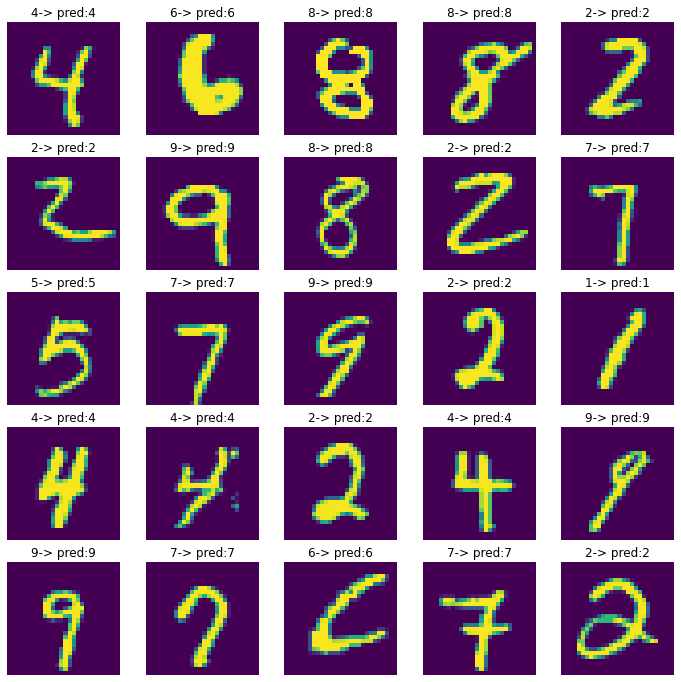

In [8]:
#visualize the prediction given by the model. the most has test accuracy of 98.99% 

figure = plt.figure(figsize = (12,12))
cols, rows = 5,5
for i in range(1, cols*rows + 1):
    index = torch.randint(len(data_test), size = (1,)).item()
    figure.add_subplot(rows, cols, i)
    img = data_test[index][0]
    label = data_test[index][1]
    #------------------------------
    features = img
    features = features.to(device)
    out = Lenet(features)
    pred = torch.max(out,1)[1]
    #-----------------------------
    plt.title(f"{label}-> pred:{pred.item()}")
    plt.axis("off")
    plt.imshow(img.view(28,28))

    #plt.imshow(img.numpy().squeeze(),cmap="Greys")           # .squeeze() flattens the given tensor or matrix into 1-d array.
plt.show()

### Fast Gradient Sign Method ( FGSM method ) attack


In [9]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image



In [11]:
def test( model, device, test_loader, epsilon ):
    """
    Applies the FGSM attack on the test dataset and calculates the accuracy on pre-trained model using adversarial
    images. 
    
    Args : 
        model : the model to be attacked 
        device : "cuda" if available else "cpu"
        test_loader : DataLoader consists of images and labels with batch size 1
        epsilon : the amount of pertubation to be added in the original image.
    """

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [12]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
device = 'cuda' if torch.cuda.is_available else 'cpu'

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(Lenet, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9899 / 10000 = 0.9899
Epsilon: 0.05	Test Accuracy = 9415 / 10000 = 0.9415
Epsilon: 0.1	Test Accuracy = 8298 / 10000 = 0.8298
Epsilon: 0.15	Test Accuracy = 6938 / 10000 = 0.6938
Epsilon: 0.2	Test Accuracy = 6008 / 10000 = 0.6008
Epsilon: 0.25	Test Accuracy = 5406 / 10000 = 0.5406
Epsilon: 0.3	Test Accuracy = 4979 / 10000 = 0.4979


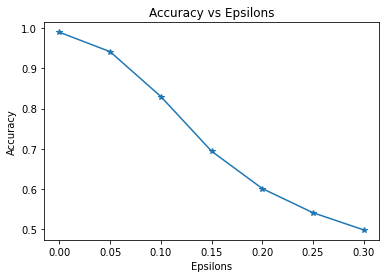

In [13]:

plt.plot(epsilons,accuracies, "*-")
plt.xlabel("Epsilons")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epsilons")
plt.show()

### Using the torch attack library for the FGSM attack and comparing the accuracy.

In [19]:
from torchattacks.attacks import fgsm

In [43]:
#generate FGSM attacks with different epsilon values.

adv_examples = {
    0:[],
    .05:[],
    .10:[],
    .15:[],
    .20:[],
    .25:[],
    .30:[]
}


for eps in epsilons:
    fgsm_attack = fgsm.FGSM(Lenet, eps)
    for image, labels in test_loader:
        adv_images = fgsm_attack(image, labels)
        adv_examples[eps].append((adv_images,labels))
    

In [120]:
#calculate the accuracy at different epsilon values of the adversarial images. 


accuracy_library = []
for eps in adv_examples:
    correct = 0
    length = len(adv_examples[eps])
    for i in range(length):
        #this loop goes over all the examples generated with different epsilons and calculates the accuracy.
        out = Lenet(adv_examples[eps][i][0])
        prediction = torch.max(out, 1)[1]
        label = adv_examples[eps][i][1].item()
        #print(f"the label was {adv_examples[eps][i][1]} while the pred was {prediction.item()}")
        if prediction.item() == label:
            correct += 1
        
    accuracy = correct / float(length)
    accuracy_library.append(accuracy)
    print(f"Epsilon : {eps} , accuracy = {correct} / {length} = {accuracy}")
        
        

Epsilon : 0 , accuracy = 9899 / 10000 = 0.9899
Epsilon : 0.05 , accuracy = 9415 / 10000 = 0.9415
Epsilon : 0.1 , accuracy = 8253 / 10000 = 0.8253
Epsilon : 0.15 , accuracy = 6363 / 10000 = 0.6363
Epsilon : 0.2 , accuracy = 4525 / 10000 = 0.4525
Epsilon : 0.25 , accuracy = 3114 / 10000 = 0.3114
Epsilon : 0.3 , accuracy = 2180 / 10000 = 0.218


In [121]:
print(accuracy_library)

[0.9899, 0.9415, 0.8253, 0.6363, 0.4525, 0.3114, 0.218]


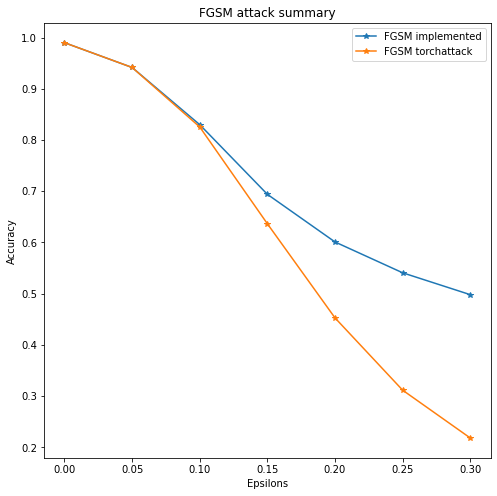

In [122]:
plt.figure(figsize=(8,8))
plt.plot(epsilons, accuracies, "*-", label = "FGSM implemented",)
plt.plot(epsilons, accuracy_library, "*-", label ="FGSM torchattack")
plt.legend()
plt.xlabel("Epsilons")
plt.ylabel("Accuracy")
plt.title("FGSM attack summary")
plt.show()

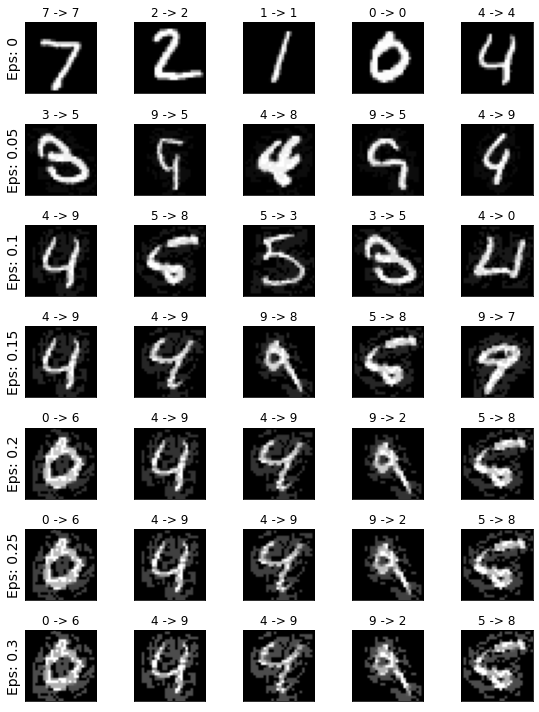

In [72]:
# Plot several examples of adversarial samples at each epsilon that was generated from the function I implemented
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Projected Gradient Descent Attack (PGD) attack

In [73]:
loss = nn.CrossEntropyLoss()    


In [95]:
#function that returns an adversarial instance of the original image 
def pgd_attack(model, images, labels, epsilon, alpha=2/255, num_iter=10):
    """
    Applies the Projected Gradient Descent (PGD) attack on a given model.

    Args:
        model (torch.nn.Module): The model to be attacked.
        images (torch.Tensor): Batch of input images.
        labels (torch.Tensor): True labels corresponding to  input images.
        epsilon (float): Perturbation limit (default: 0.03).
        alpha (float): Step size for each iteration (default: 0.01).
        num_iter (int): Number of iterations to perform (default: 40).

    Returns:
        torch.Tensor: Adversarial images generated by the attack.
    """
    images = images.clone().detach().requires_grad_(True)
    perturbations = torch.zeros_like(images)

    for _ in range(num_iter):
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            # Update the perturbations using the gradient
            perturbations = perturbations + alpha * images.grad.sign()

            # Project the perturbations onto the epsilon ball around the original images
            perturbations = torch.clamp(perturbations, -epsilon, epsilon)
            adversarial_images = torch.clamp(images + perturbations, 0, 1)

        images = adversarial_images.clone().detach().requires_grad_(True)

    return adversarial_images


In [96]:
#generate adversarial images and store it in a dict
epsilons = [0, .05, .1, .15, .2, .25, .3]
pgd_adv_examples = {
    0:[],
    .05:[],
    .10:[],
    .15:[],
    .20:[],
    .25:[],
    .30:[]
}


for eps in epsilons:
    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        adversarial = pgd_attack(Lenet, image, label, eps)
        pgd_adv_examples[eps].append((adversarial, label))   #append a tuple with the adversarial image and it's label




In [97]:

accuracy_list = []
for eps in pgd_adv_examples:
    correct = 0
    length = len(pgd_adv_examples[eps])
    for i in range(length):
        #calculate the predictions for the adversarial examples.
        out = Lenet(pgd_adv_examples[eps][i][0])
        prediction = torch.max(out, 1)[1]
        label = pgd_adv_examples[eps][i][1].item()
        #check the accuracy
        if prediction.item() == label:
            correct += 1
    
    accuracy = correct / float(length)
    accuracy_list.append(accuracy)
    print(f"Epsilon : {eps} , accuracy = {correct} / {length} = {accuracy}")
    

Epsilon : 0 , accuracy = 9899 / 10000 = 0.9899
Epsilon : 0.05 , accuracy = 144 / 10000 = 0.0144
Epsilon : 0.1 , accuracy = 85 / 10000 = 0.0085
Epsilon : 0.15 , accuracy = 85 / 10000 = 0.0085
Epsilon : 0.2 , accuracy = 85 / 10000 = 0.0085
Epsilon : 0.25 , accuracy = 85 / 10000 = 0.0085
Epsilon : 0.3 , accuracy = 85 / 10000 = 0.0085


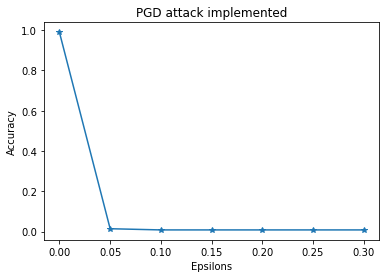

In [98]:
plt.plot(epsilons, accuracy_list, "*-")
plt.xlabel("Epsilons")
plt.ylabel("Accuracy")
plt.title("PGD attack implemented")
plt.show()

In [110]:
from torchattacks.attacks import pgd

pgd_attack = { 
     0:[],
    .05:[],
    .10:[],
    .15:[],
    .20:[],
    .25:[],
    .30:[]
}


for eps in epsilons:
    attack = pgd.PGD(Lenet, eps)
    for image, label in test_loader:
        adv_eg = attack(image, label)
        pgd_attack[eps].append((adv_eg, label))

In [111]:
accuracy_list_pgd = []
for eps in pgd_attack:
    correct = 0
    length = len(pgd_attack[eps])
    for i in range(length):
        #calculate the predictions for the adversarial examples.
        out = Lenet(pgd_attack[eps][i][0])
        prediction = torch.max(out, 1)[1]
        label = pgd_attack[eps][i][1].item()
        #check the accuracy
        if prediction.item() == label:
            correct += 1
    
    accuracy = correct / float(length)
    accuracy_list_pgd.append(accuracy)
    print(f"Epsilon : {eps} , accuracy = {correct} / {length} = {accuracy}")
    

Epsilon : 0 , accuracy = 9899 / 10000 = 0.9899
Epsilon : 0.05 , accuracy = 9192 / 10000 = 0.9192
Epsilon : 0.1 , accuracy = 8097 / 10000 = 0.8097
Epsilon : 0.15 , accuracy = 7410 / 10000 = 0.741
Epsilon : 0.2 , accuracy = 6800 / 10000 = 0.68
Epsilon : 0.25 , accuracy = 6013 / 10000 = 0.6013
Epsilon : 0.3 , accuracy = 5104 / 10000 = 0.5104


In [112]:
print(accuracy_list_pgd)

[0.9899, 0.9192, 0.8097, 0.741, 0.68, 0.6013, 0.5104]


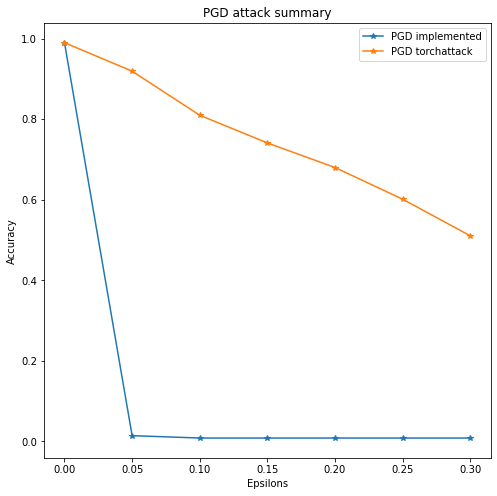

In [113]:
plt.figure(figsize=(8,8))
plt.plot(epsilons, accuracy_list, "*-", label = "PGD implemented",)
plt.plot(epsilons, accuracy_list_pgd, "*-", label ="PGD torchattack")
plt.legend()
plt.xlabel("Epsilons")
plt.ylabel("Accuracy")
plt.title("PGD attack summary")
plt.show()